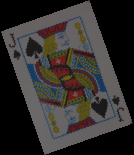

In [25]:
import torch
from PIL import ImageChops
from util import fake_image
from random import choice, randint, sample
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image, pil_to_tensor, resized_crop
from torchvision.transforms.v2 import Compose, Resize, ToImage, ToPILImage, ToDtype, ScaleJitter, RandomResize, RandomRotation, RandomAffine, RandomPerspective, ColorJitter, ConvertBoundingBoxFormat, RandomResizedCrop

card_transform = Compose([
    RandomResize(50, 224),
    ColorJitter(brightness=(0.5, 1.0), contrast=(0.5, 1.0)),
    RandomRotation(30, expand=True),
    RandomPerspective(0.3),
])

cards = ImageFolder(r'../data/playing_cards', transform=card_transform)
choice(cards)[0]

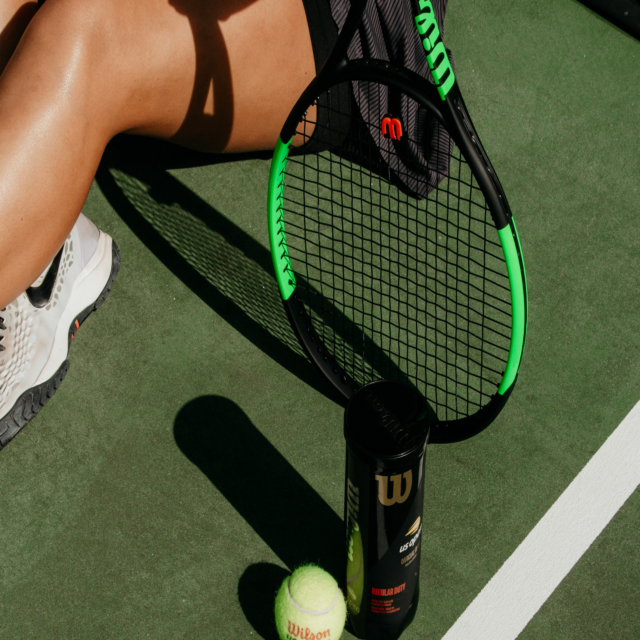

In [27]:
from pathlib import Path
from PIL import Image

class RandomBackground(torch.nn.Module):
    def __init__(self, source, size=640, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.files = list(Path(source).glob('*.jpg'))
        self.crop = RandomResizedCrop(size)
    
    def forward(self):
        path = choice(self.files)
        with open(path, "rb") as f:
            img = Image.open(f)
            return self.crop(img.convert("RGB"))
random_background = RandomBackground(r'../data/sample_images')
random_background()

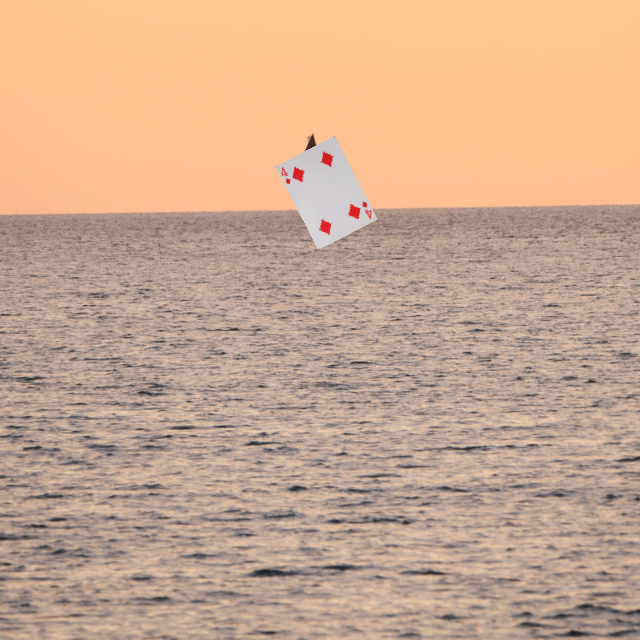

In [28]:

img = choice(cards)[0]
height, width = img.height, img.width
# display(img)
x = randint(0, 448-width)
y = randint(0, 448-height)
background = pil_to_tensor(random_background())
img = pil_to_tensor(img)
mask = torch.zeros_like(background)
mask[:, y:y+height, x:x+width] = img
# display(to_PIL(mask))
background[:, (mask >  0).any(0)] = 0
# display(to_PIL((mask >  0).to(dtype=torch.uint8)*255))
# display(to_PIL(background))
final = mask | background
to_pil_image(final)

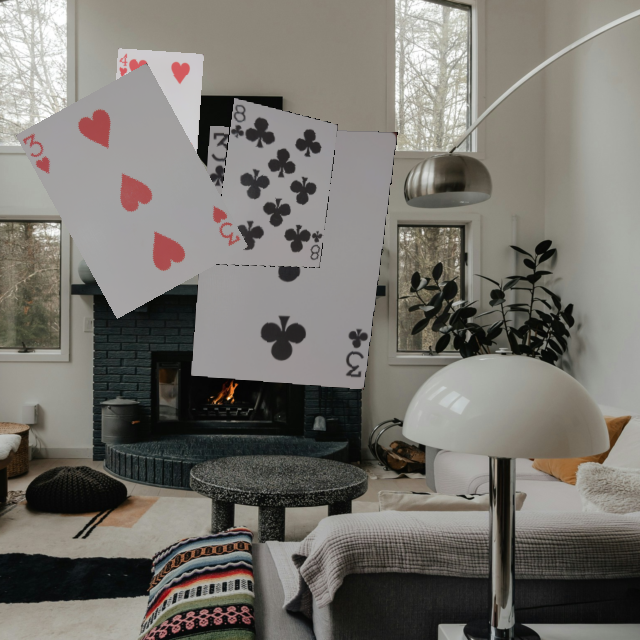

In [24]:

class AddBackground(torch.nn.Module):
    def __init__(self, width=448, height=448, PIL=True) -> None:
        super().__init__()
        self.width = width
        self.height = height
        self.PIL = PIL

    def forward(self, samples):
        background = pil_to_tensor(random_background()) #(self.height, self.width, PIL=False)
        labels = []
        for img, label in samples:
            height, width = img.height, img.width
            x = randint(0, self.width-width)
            y = randint(0, self.height-height)
            img = pil_to_tensor(img)
            mask = torch.zeros_like(background)
            mask[:, y:y+height, x:x+width] = img
            background[:, (mask >  0).any(0)] = 0
            background = mask | background
            cx = (x + width // 2) / self.width
            cy = (y + height // 2) / self.height
            labels.append(f'{label} {cx} {cy} {width / self.width} {height / self.height}')  # class cx cy width height
        if self.PIL:
            return to_pil_image(background), '\n'.join(labels)
        return background, '\n'.join(labels)
add = AddBackground(PIL=True)
card_imgs = [choice(cards), choice(cards), choice(cards), choice(cards)]
add(card_imgs)[0]